<a href="https://colab.research.google.com/github/IMonukushwaha/COVID-19-Chest-X-Ray-Classification-using-CNN/blob/main/covid_detection_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout

In [3]:
import os
import shutil
import random

In [4]:
from keras.preprocessing import image_dataset_from_directory

In [5]:
PATH = '/content/drive/MyDrive/IMp_documents/archive (2)'
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [6]:
dataset = image_dataset_from_directory(
    PATH + '',
    seed = 42,
    shuffle = True,
    image_size = (IMAGE_SIZE , IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 6920 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names
class_names

['covid', 'normal', 'pneumonia']

In [8]:
# from matplotlib import pyplot as plt

# plt.figure(figsize=(12, 12))
# for image_batch, labels_batch in dataset.take(1):
#   for i in range(16):
#     ax = plt.subplot(4, 4, i + 1)
#     plt.imshow(image_batch[i].numpy().astype("uint8"))
#     plt.title(class_names[labels_batch[i]])
#     plt.axis("off")

In [9]:
train_size = 0.8
validation_size = 0.2

In [10]:
train_batch = int(len(dataset) * train_size)
train_ds = dataset.take(train_batch)
val_batch = int(len(dataset) * validation_size)
val_ds = dataset.skip(train_batch).take(val_batch)

In [11]:
#normalize the ds
from keras.applications.resnet50 import preprocess_input

def process_image(image, label):
    image = preprocess_input(image)
    return image, label

train_ds = train_ds.map(process_image)
val_ds = val_ds.map(process_image)

In [12]:
train_ds.element_spec
val_ds.element_spec

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [13]:
from keras import layers

In [14]:
#data augmentation
data_augmentation = keras.Sequential([
    layers.RandomRotation(0.15)
])

In [15]:
#applying dA to the training data
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

In [17]:
from keras.applications.resnet50 import ResNet50

In [18]:
Resnet_base = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(256, 256, 3)
    )

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [19]:
Resnet_base.trainable = False

# set_trainable = False

# for layer in Resnet_base.layers:
#   if layer.name == 'conv5_block1_1_conv':
#     set_trainable = True
#   if set_trainable:
#     layer.trainable = True
#   else:
#     layer.trainable = False

# for layer in Resnet_base.layers[-10:]:
#     layer.trainable = True

for layer in Resnet_base.layers:
  print(layer.name, layer.trainable)

input_layer_1 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_3_bn False
conv2_block2_add False
conv2_block2_out False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
conv2_block3_3_conv False
conv2_block3_3_bn False
conv2_block3_add False
conv2_block3_out False
conv3_block1_1_conv False
conv3_block1_1_bn False
conv3_block1_1_relu False
conv3_block1

In [20]:
from keras.layers import Reshape, AveragePooling2D

In [21]:
model = Sequential()

model.add(Resnet_base)
model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(1e-4)))

In [22]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │   134,218,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158,074,755 (603.01 MB)

 Trainable params: 134,484,483 (513.02 MB)

 Non-trainable params: 23,590,272 (89.99 MB)

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0003),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [24]:
callback = [
    tf.keras.callbacks.ModelCheckpoint(filepath='model.keras'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6)
]

In [25]:
history = model.fit(train_ds,
                    batch_size=32,
                    epochs=8,
                    validation_data=val_ds,
                    callbacks=callback,
                    verbose=1
                    )

Epoch 1/8
173/173 ━━━━━━━━━━━━━━━━━━━━ 2732s 16s/step - accuracy: 0.8474 - loss: 0.7878 - val_accuracy: 0.9419 - val_loss: 0.4872 - learning_rate: 3.0000e-04
Epoch 2/8
173/173 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - accuracy: 0.9770 - loss: 0.3294 - val_accuracy: 0.9571 - val_loss: 0.4141 - learning_rate: 3.0000e-04
Epoch 3/8
173/173 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.9992 - loss: 0.2417 - val_accuracy: 0.9542 - val_loss: 0.4088 - learning_rate: 3.0000e-04
Epoch 4/8
173/173 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.9998 - loss: 0.2057 - val_accuracy: 0.9564 - val_loss: 0.3592 - learning_rate: 3.0000e-04
Epoch 5/8
173/173 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.9996 - loss: 0.1804 - val_accuracy: 0.9477 - val_loss: 0.3626 - learning_rate: 3.0000e-04
Epoch 6/8
173/173 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.9913 - loss: 0.1865 - val_accuracy: 0.9491 - val_loss: 0.5043 - learning_rate: 3.0000e-04
Epoch 7/8
173/173 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy

In [26]:
# history = model.fit(train_ds,
#                     batch_size=32,
#                     epochs=5,
#                     initial_epoch=2,
#                     validation_data=val_ds,
#                     callbacks=callback,
#                     verbose=1
#                     )

In [27]:
# history = model.fit(train_ds,
#                     batch_size=32,
#                     epochs=10,
#                     initial_epoch=5,
#                     validation_data=val_ds,
#                     callbacks=callback,
#                     verbose=1
#                     )

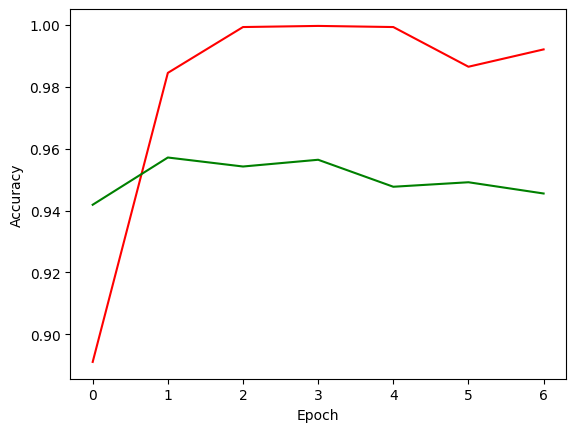

In [28]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy', color='red')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [29]:
from keras.models import load_model
model = load_model('model.keras')

In [30]:
import numpy as np
all_predictions = []
all_labels = []
for images, labels in val_ds:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    all_predictions.extend(predicted_classes)
    all_labels.extend(labels.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [31]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
accuracy = accuracy_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')

print("Accuracy: ", accuracy)
print("F1 Score: ", f1)
print("Recall: ", recall)
print("Precision: ", precision)

Accuracy:  0.9454941860465116
F1 Score:  0.9452954991429671
Recall:  0.9454941860465116
Precision:  0.9460559837945686


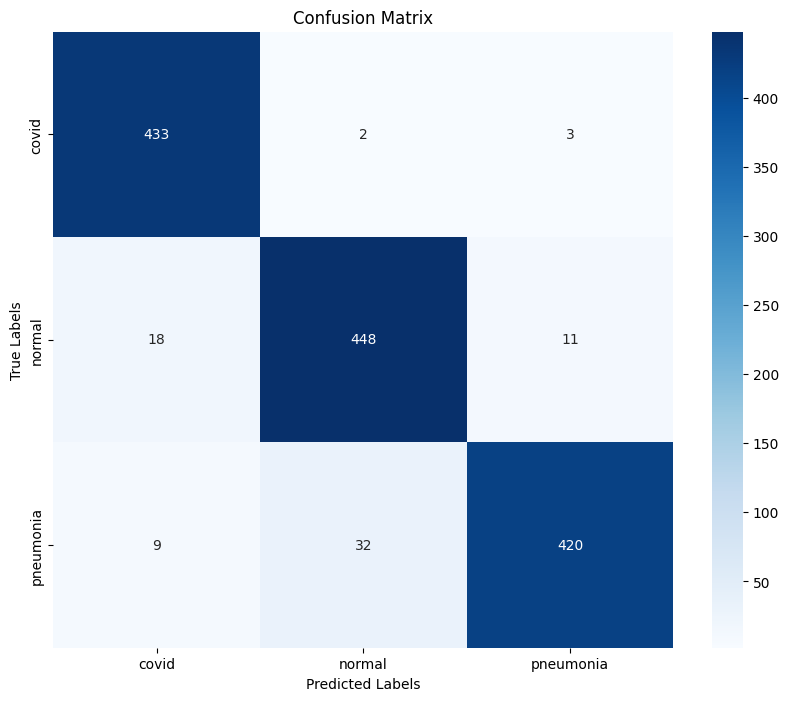

In [32]:
import seaborn as sns
from seaborn import heatmap
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.savefig('Confusion Matrix.png', dpi = 300)
plt.show()

Accuracy and losses

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

ValueError: x and y must have same first dimension, but have shapes (2,) and (7,)

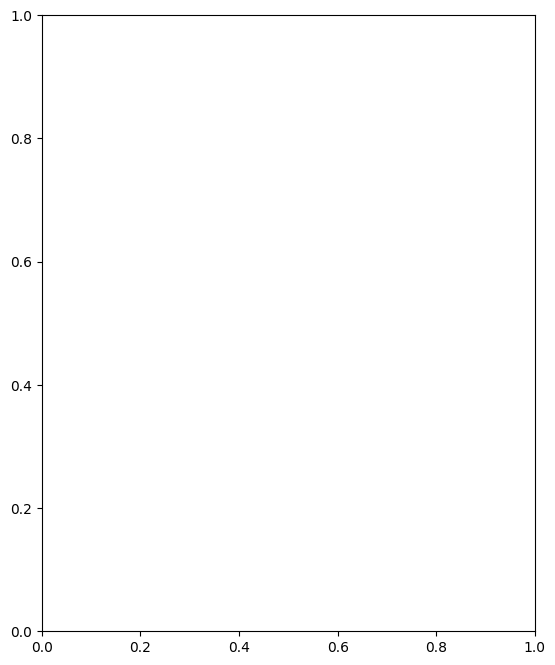

In [34]:
EPOCHS = 2
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('curves.png', dpi = 300)
plt.show()